# 0.1.0 Load Visium Data

See [Space Ranger documentation](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview) - paraphrased below:

### tissue_positions_list.txt 
This text file contains a table with rows that correspond to spots. It has 4,992 rows, which is the number of spots in the spatial array. Columns, whose names are not specified in the file, correspond to the following fields:

* barcode: The sequence of the barcode associated to the spot.
* in_tissue: Binary, indicating if the spot falls inside (1) or outside (0) of tissue.
* array_row: The row coordinate of the spot in the array from 0 to 77. The array has 78 rows.
* array_col: The column coordinate of the spot in the array. In order to express the orange crate arrangement of the spots, this column index uses even numbers from 0 to 126 for even rows, and odd numbers from 1 to 127 for odd rows. Notice then that each row (even or odd) has 64 spots.
* pxl_col_in_fullres: The column pixel coordinate of the center of the spot in the full resolution image.
* pxl_row_in_fullres: The row pixel coordinate of the center of the spot in the full resolution image.

### Predict Cell Types Using Reference Dataset

This paper is referenced in the Seurat tutorial:

paper: https://www.nature.com/articles/nn.4216

data: http://casestudies.brain-map.org/celltax#section_explorea

The Seurat tutorial references this package: 
https://github.com/Teichlab/SpatialDE

In [1]:
import sys
import importlib
import himc_helper_functions as hf
importlib.reload(hf)
hf.get_version()

0.12.3 cleaning vdj code


In [2]:
import pandas as pd
from copy import deepcopy
from clustergrammer2 import net

>> clustergrammer2 backend version 0.5.6


In [3]:
import ipywidgets as widgets
import numpy as np
from bqplot import pyplot as plt
import bqplot

from copy import deepcopy
from glob import glob
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import Voronoi

import warnings
warnings.filterwarnings('ignore')

In [4]:
def make_df_from_cols(cols):
    inst_col = cols[0]

    cat_titles = []
    for inst_info in inst_col[1:]:
        inst_title = inst_info.split(': ')[0]
        cat_titles.append(inst_title)

    clean_cols = []
    for inst_col in cols:
        inst_clean = []
        for inst_info in inst_col:
            if ': ' in inst_info:
                inst_clean.append(inst_info.split(': ')[1])
            else:
                inst_clean.append(inst_info)
        clean_cols.append(tuple(inst_clean))

    df_ini = pd.DataFrame(data=clean_cols).set_index(0)
    mat = df_ini.get_values()
    rows = df_ini.index.tolist()

    print(mat.shape)
    print(len(rows))
    print(len(clean_cols))

    df_meta = pd.DataFrame(data=mat, index=rows, columns=cat_titles)

    return df_meta

In [5]:
base_dir = 'data/primary/V1_Mouse_Brain_Sagittal_Anterior/'

In [6]:
feat_data = hf.load_crv3_feature_matrix(base_dir + 'filtered_feature_bc_matrix/')

In [7]:
df = hf.convert_to_dense(feat_data)

In [8]:
df = hf.ini_meta_cell(df=df)

In [9]:
df.keys()

dict_keys(['gex', 'meta_cell'])

In [10]:
df['meta_cell'].head()

,gex-umi-sum,num_expressed_genes
AAACAAGTATCTCCCA,13069,4242
AAACACCAATAACTGC,37448,7860
AAACAGAGCGACTCCT,28475,6332
AAACAGCTTTCAGAAG,39718,7957
AAACAGGGTCTATATT,33392,7791


In [11]:
df = hf.filter_ribo_mito_from_gex(df)
df['meta_cell'].head()

,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000
AAACACCAATAACTGC,37448,7860,19.809524,256.666667
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000


In [12]:
df['gex'].shape

(30933, 2696)

In [13]:
df.keys()

dict_keys(['gex', 'meta_cell', 'gex-mr'])

### Load Spatial Data

In [14]:
cols = ['in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres']
df_pos = pd.read_csv(base_dir + 'spatial/tissue_positions_list.csv', header=None, index_col=0)
df_pos.columns = cols
df_pos.index.name = None
df_pos.index = [x.split('-')[0] for x in df_pos.index.tolist()]
print(df_pos.shape)

(4992, 5)


#### Keep beads in tissue only

In [15]:
df_pos = deepcopy(df_pos[df_pos['in_tissue'] == 1])
df_pos.shape

(2696, 5)

In [16]:
rows_pos = df_pos.index.tolist()
rows_gex = df['meta_cell'].index.tolist()
print(len(rows_pos))
print(len(rows_gex))

2696
2696


In [17]:
df_meta = pd.concat([df['meta_cell'], df_pos], axis=1)
df_meta.shape

(2696, 9)

In [18]:
df_meta.head()

,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000,1,50,102,7475,8501
AAACACCAATAACTGC,37448,7860,19.809524,256.666667,1,59,19,8553,2788
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333,1,14,94,3164,7950
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000,1,43,9,6637,2099
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000,1,47,13,7116,2375


#### Define Position in Preferred Coordinate System

In [19]:
df_meta['pos-x'] = df_meta['pxl_row_in_fullres'].apply(lambda x: x)
df_meta['pos-y'] = df_meta['pxl_col_in_fullres'].apply(lambda x: df_meta['pxl_col_in_fullres'].max() - x)

### Color by UMI

In [20]:
max_umi = df_meta['gex-umi-sum'].max()
mean_umi = df_meta['gex-umi-sum'].mean()
print(max_umi, mean_umi)

67119 24269.346439169138


In [21]:
df_meta['gex-umi-sum-norm'] = df_meta['gex-umi-sum'].apply(lambda x: x/max_umi )

In [22]:
ser_color = df_meta['gex-umi-sum'].apply(lambda x: (0, 0, 1, x/max_umi) )
list_colors = list(ser_color.get_values())
list_colors[0]

(0, 0, 1, 0.19471386641636496)

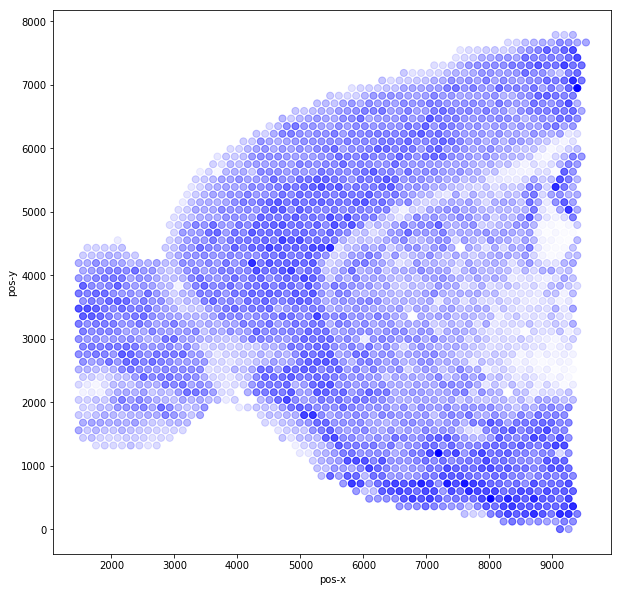

In [23]:
df_meta.plot(kind='scatter', 
             x='pos-x', 
             y='pos-y', 
            figsize=(10,10), 
             c=list_colors, 
            s=50)

# Load Signatures

In [24]:
df_sig = pd.read_csv('data/primary/allen_brain_atlas/sig_sub_class.csv', index_col=0)
df_sig = df_sig.drop(axis=1, columns=['Unknown', 'nan'])

In [25]:
net.load_df(df_sig)
net.normalize(axis='row', norm_type='zscore')
df_sig_z = net.export_df()
net.swap_nan_for_zero()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "0610011F06Rik", "ini": 1513, "clust": 587, "rank": 1231, "rank…

# Predict Cell Type

In [26]:
df['gex-umi'] = net.umi_norm(df['gex'])
net.load_df(df['gex-umi'])
net.normalize(axis='row', norm_type='zscore')
net.swap_nan_for_zero()
df['gex-umi-z'] = net.export_df()

In [27]:
df_pred_cat_dim, df_sim, y_info = net.predict_cats_from_sigs(df_data_ini=df['gex-umi-z'], df_sig_ini=df_sig_z, 
                                                             predict_level='Predict')
# df_pred_cat = deepcopy(df_cat)
# df_pred_cat.columns = df_pred_cat_dim.columns.tolist()

In [28]:
rows_sig = df_sig.index.tolist()
rows_gex = df['gex'].index.tolist()
len(set(rows_sig).intersection(rows_gex))

1367

In [29]:
df_pred_cat_dim.shape

(1367, 2696)

In [30]:
net.load_df(df_pred_cat_dim)
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "Cntnap5c", "ini": 250, "clust": 231, "rank": 7, "rankvar": 2, …

In [31]:
df_meta_ct= make_df_from_cols(df_pred_cat_dim.columns.tolist())
df_meta_ct.head()

(2696, 1)
2696
2696


,Predict
AAACAAGTATCTCCCA,Pvalb
AAACACCAATAACTGC,Pvalb
AAACAGAGCGACTCCT,L2/3
AAACAGCTTTCAGAAG,Vip
AAACAGGGTCTATATT,Vip


In [32]:
df_meta['Cell Type'] = df_meta_ct['Predict']

# Visualize GEX

In [33]:
df['gex-cat'] = deepcopy(df['gex-umi'])
cols = df['gex-cat'].columns

add_cat_list = ['Cell Type', 'gex-umi-sum-norm']

new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, df_meta=df_meta, barcodes=cols)
df['gex-cat'].columns = new_cols

### Generate Dendrogram Categories

In [34]:
net.load_df(df['gex-cat'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.cluster()
net.dendro_cats(axis='col', dendro_level=6)
net.cluster()
net.dendro_cats(axis='col', dendro_level=4)
df_tmp = net.export_df()

In [35]:
meta_dendro = make_df_from_cols(df_tmp.columns.tolist())
meta_dendro.head()

(2696, 4)
2696
2696


,Cell Type,gex-umi-sum-norm,Group 6,Group 4
AAACAAGTATCTCCCA,Pvalb,0.19471386641636496,cat-5,cat-115
AAACACCAATAACTGC,Pvalb,0.5579344149942639,cat-4,cat-100
AAACAGAGCGACTCCT,L2/3,0.42424648758175776,cat-2,cat-35
AAACAGCTTTCAGAAG,Vip,0.5917549427136877,cat-4,cat-90
AAACAGGGTCTATATT,Vip,0.4975044324259897,cat-4,cat-90


In [52]:
df['gex-cat'] = deepcopy(df['gex-umi'])
cols = df['gex-cat'].columns

# add_cat_list = ['Cell Type', 'Group 6', 'Group 4', 'gex-umi-sum-norm']
add_cat_list = ['Cell Type',  'gex-umi-sum-norm']

new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, df_meta=meta_dendro, barcodes=cols)
df['gex-cat'].columns = new_cols

In [53]:
df['gex-cat'].shape

(250, 2696)

In [54]:
net.load_df(df['gex-cat'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
df['gex-cat-z'] = net.export_df()
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "Bc1", "ini": 250, "clust": 48, "rank": 203, "rankvar": 217, "g…

In [55]:
net.save_dict_to_json(inst_dict=net.viz, filename='data/processed/pre-calc-viz.json', indent=False)

In [40]:
keep_genes = df_tmp.index.tolist()
len(keep_genes)

250

In [41]:
df['gex-umi'] = net.umi_norm(df['gex'])
df['gex-umi'].sum(axis=0).mean()

1.0000000000000004

In [42]:
df['gex-umi'] = df['gex-umi'].loc[keep_genes] 

In [43]:
df['gex-umi'].max(axis=1).mean()

0.010325315965521532

In [44]:
max_gene = df['gex-umi'].max(axis=1)

### Divide Each Gene by Maximum Gene Level

In [45]:
df['gex-norm'] = df['gex-umi'].transpose().divide(max_gene).transpose()

In [46]:
df['gex-norm'].shape

(250, 2696)

In [47]:
df['gex-norm'].max(axis=1).mean()

1.0

In [48]:
# net.load_df(df['gex-norm'])
# net.normalize(axis='row', norm_type='zscore')
# net.clip(-5,5)
# df_tmp = net.export_df()
# net.widget()

In [49]:
df['gex-norm'].to_csv('data/processed/gex.csv')
df['gex-cat-z'].to_csv('data/processed/gex-z.csv')

### Save Metadata

In [50]:
df_meta.shape

(2696, 13)

In [51]:
df_meta.to_csv('data/processed/df_meta.csv')